<a href="https://colab.research.google.com/github/jarinari/Algorithmic-Trading-Plugins/blob/master/descorrelacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENTORNO

In [ ]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#DATOS

In [ ]:
url = 'https://drive.google.com/uc?id=1We66GFgIXe9o5tA3vzVprHwvYj0rJErm'
output = "archivo.csv"
gdown.download(url, output, quiet=True)
data = pd.read_csv(output)
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)
data.head(5)

,JTL,SYO,ZVQ,WGP,YOX,ERQ,BAX,WNJ,UYZ,PKG,UAE,TXR,TRO,ZCD,JHU,KNT,YAX,THA,SGP,BSX
Date,,,,,,,,,,,,,,,,,,,,
2022-04-17,0.779144,0.163344,0.000000,0.171714,-0.229613,0.000000,0.0,-0.120453,0.048082,0.111601,-0.315736,0.288357,0.055586,0.245376,0.473444,0.0,0.0,0.0,-0.486783,-0.823092
2022-04-18,0.048624,0.922872,-0.567304,-0.457119,-0.489978,0.000000,0.0,-0.160798,1.219963,0.217085,-0.088686,-0.151901,-0.005556,0.269253,-0.199104,0.0,0.0,0.0,-0.991915,1.114143
2022-04-19,1.511470,-0.124862,0.401768,0.323540,0.156670,0.129790,0.0,-0.265743,-0.007305,-0.292723,-0.317017,0.249932,0.238902,-0.884929,0.219451,0.0,0.0,0.0,0.096068,-0.685856
2022-04-20,0.454828,-0.808942,-0.113057,0.000000,-0.044693,-0.482841,0.0,-0.952765,-0.398130,1.597088,-0.228979,0.135494,-0.055426,-0.674240,-0.258784,0.0,0.0,0.0,1.055735,0.000000
2022-04-21,0.743494,-1.293743,-0.189137,0.000000,-0.849542,0.400521,0.0,0.652156,-0.036672,-0.676183,0.433508,0.000000,0.144188,0.756308,0.000000,0.0,0.0,0.0,1.892680,1.335899


#PARTICIÓN

In [ ]:
train = data[data.index<'2023-06-01']
test = data[data.index>'2023-05-31']

#RANKING

In [ ]:
sharpes = []
for darwin in train.columns:
  sharpe = train[darwin].mean()/train[darwin].std()
  sharpes.append(sharpe)

df_sharpe = pd.DataFrame({'Sharpe': sharpes})
df_sharpe.index = train.columns
df_sharpe = df_sharpe.sort_values('Sharpe', ascending=False)
df_sharpe.head(5)

,Sharpe
THA,0.199268
YOX,0.149177
WNJ,0.128176
SGP,0.104557
TXR,0.099841


#DESCORRELACIÓN RETORNOS

In [ ]:
df_corr_returns = train.corr().unstack().reset_index()
df_corr_returns.columns = ['Variable 1', 'Variable 2', 'Correlación']
df_corr_returns = df_corr_returns[df_corr_returns['Variable 1'] != df_corr_returns['Variable 2']]
df_corr_returns[['Variable 1', 'Variable 2']] = np.sort(df_corr_returns[['Variable 1', 'Variable 2']].values, axis=1)
df_corr_returns = df_corr_returns.drop_duplicates()
df_corr_returns = df_corr_returns.sort_values('Correlación', ascending=False)
df_corr_returns.head(5)

,Variable 1,Variable 2,Correlación
136,BAX,YAX,0.889032
337,THA,YAX,0.434715
127,BAX,WNJ,0.342963
137,BAX,THA,0.291323
156,WNJ,YAX,0.277657


In [ ]:
correlateds_returns = []
for index, row in df_corr_returns.iterrows():
  var1 = row['Variable 1']
  var2 = row['Variable 2']
  ratio_var1 = df_sharpe.loc[df_sharpe.index == var1, 'Sharpe'].values[0]
  ratio_var2 = df_sharpe.loc[df_sharpe.index == var2, 'Sharpe'].values[0]
  if ratio_var1 < ratio_var2:
    if var1 not in correlateds_returns:
      correlateds_returns.append(var1)
  else:
    if var2 not in correlateds_returns:
      correlateds_returns.append(var2)
  if len(correlateds_returns)==15:
    break
print('Elementos a eliminar: ', correlateds_returns)

Elementos a eliminar:  ['YAX', 'BAX', 'ZCD', 'ZVQ', 'BSX', 'SYO', 'JHU', 'UAE', 'SGP', 'PKG', 'ERQ', 'YOX', 'UYZ', 'WGP', 'JTL']


In [ ]:
sel_returns = [elemento for elemento in list(train.columns) if elemento not in correlateds_returns]

#DESCORRELACIÓN DRAWDOWNS

In [ ]:
drawdowns = {}
for column in train.columns:
  series = train[column]
  running_max = np.maximum.accumulate(series)
  drawdown = series - running_max
  drawdown_by_month = drawdown.groupby(drawdown.index.to_period('W')).min()
  drawdowns[column] = drawdown_by_month
train_dds = pd.DataFrame(drawdowns)
train_dds.head(5)

,JTL,SYO,ZVQ,WGP,YOX,ERQ,BAX,WNJ,UYZ,PKG,UAE,TXR,TRO,ZCD,JHU,KNT,YAX,THA,SGP,BSX
Date,,,,,,,,,,,,,,,,,,,,
2022-04-11/2022-04-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2022-04-18/2022-04-24,-1.056641,-2.216614,-0.590906,-0.628833,-1.006211,-0.612631,0.000000,-0.832313,-1.618093,-2.273271,-0.632399,-0.440258,-0.294328,-1.154182,-0.732228,0.0,0.000000,0.000000,-2.318779,-1.799998
2022-04-25/2022-05-01,-2.238844,-3.366725,-4.255842,-0.488947,-3.865363,-2.841292,-1.598768,-0.716813,-1.227301,-6.382748,-1.132986,-0.288357,-0.477195,-2.314857,-0.775529,0.0,-1.906177,-0.476927,-3.709620,-2.071096
2022-05-02/2022-05-08,-2.310082,-1.966721,-3.245232,-0.488947,-3.152944,-2.891594,-3.653347,-1.718130,-1.238089,-6.553700,-1.300044,-1.095643,-1.207668,-1.549329,-1.538938,0.0,-4.456887,-3.062090,-3.106191,-3.397981
2022-05-09/2022-05-15,-2.920313,-2.599698,-2.483667,-1.267297,-1.974561,-2.580218,-2.318154,-2.809851,-1.702896,-6.687672,-1.432082,-1.760040,-0.549430,-1.275473,-0.836608,0.0,-1.906177,-2.929669,-2.805473,-2.993248


In [ ]:
df_corr_dds = train_dds.corr().unstack().reset_index()
df_corr_dds.columns = ['Variable 1', 'Variable 2', 'Correlación']
df_corr_dds = df_corr_dds[df_corr_dds['Variable 1'] != df_corr_dds['Variable 2']]
df_corr_dds[['Variable 1', 'Variable 2']] = np.sort(df_corr_dds[['Variable 1', 'Variable 2']].values, axis=1)
df_corr_dds = df_corr_dds.drop_duplicates()
df_corr_dds = df_corr_dds.sort_values('Correlación', ascending=False)
df_corr_dds.head(5)

,Variable 1,Variable 2,Correlación
136,BAX,YAX,0.875740
295,JHU,KNT,0.853317
316,KNT,YAX,0.843941
44,YOX,ZVQ,0.805699
296,JHU,YAX,0.795729


In [ ]:
correlateds_dds = []
for index, row in df_corr_dds.iterrows():
  var1 = row['Variable 1']
  var2 = row['Variable 2']
  ratio_var1 = df_sharpe.loc[df_sharpe.index == var1, 'Sharpe'].values[0]
  ratio_var2 = df_sharpe.loc[df_sharpe.index == var2, 'Sharpe'].values[0]
  if ratio_var1 < ratio_var2:
    if var1 not in correlateds_dds:
      correlateds_dds.append(var1)
  else:
    if var2 not in correlateds_dds:
      correlateds_dds.append(var2)
  if len(correlateds_dds)==15:
    break
print('Elementos a eliminar: ', correlateds_dds)

Elementos a eliminar:  ['YAX', 'JHU', 'ZVQ', 'KNT', 'BAX', 'UAE', 'WGP', 'WNJ', 'PKG', 'UYZ', 'TRO', 'YOX', 'ZCD', 'SYO', 'JTL']


In [ ]:
sel_dds = [elemento for elemento in list(train_dds.columns) if elemento not in correlateds_dds]

#COMPARACIÓN

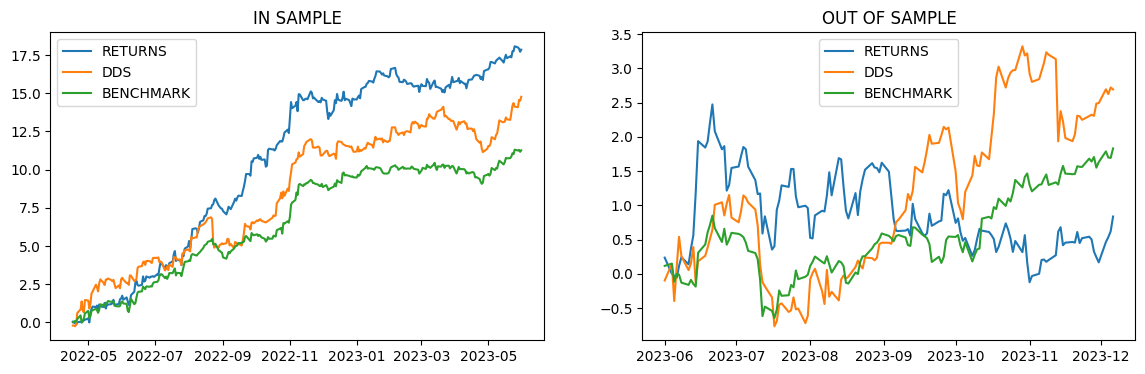

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(train[sel_returns].mean(axis=1).cumsum(), label='RETURNS')
plt.plot(train[sel_dds].mean(axis=1).cumsum(), label='DDS')
plt.plot(train.mean(axis=1).cumsum(), label='BENCHMARK')
plt.title('IN SAMPLE')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test[sel_returns].mean(axis=1).cumsum(), label='RETURNS')
plt.plot(test[sel_dds].mean(axis=1).cumsum(), label='DDS')
plt.plot(test.mean(axis=1).cumsum(), label='BENCHMARK')
plt.title('OUT OF SAMPLE')
plt.legend()
plt.show()